In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
class_map = {
    'lying down': 0,
    'lying': 0,
    'sitting down': 1,
    'sitting': 1,
    'standing up from lying': 2,
    'standing up from sitting': 2,
    'standing up from sitting on the ground': 2,
    "walking": 3,
    "falling": 4,
    'on all fours': 5,
    'sitting on the ground': 6,
} #11 to 7

sensor_ids = {
    "010-000-024-033":0,
    "010-000-030-096":1,
    "020-000-033-111":2,
    "020-000-032-221":3
}

def one_hot(x,n):
    y = np.zeros(n,dtype=np.float32)
    y[x] = 1
    return y

def load_crappy_formated_csv():

    all_x = []
    all_y = []

    series_x = []
    series_y = []

    all_feats = []
    all_labels = []
    with open("data/person/ConfLongDemo_JSI.txt","r") as f:
        current_person = "A01"

        for line in f:
            arr = line.split(",")
            if(len(arr)<6):
                break
            if(arr[0] != current_person):
                # Enque and reset
                series_x = np.stack(series_x,axis=0)
                series_y = np.array(series_y,dtype=np.int32)
                all_x.append(series_x)
                all_y.append(series_y)
                series_x = []
                series_y = []
            current_person = arr[0]
            sensor_id = sensor_ids[arr[1]]
            label_col = class_map[arr[7].replace("\n","")]
            feature_col_2 = np.array(arr[4:7],dtype=np.float32)

            feature_col_1 = np.zeros(4,dtype=np.float32)
            feature_col_1[sensor_id] = 1

            feature_col = np.concatenate([feature_col_1,feature_col_2])
            # 100ms sampling time
            # print("feature_col: ",str(feature_col))
            series_x.append(feature_col)
            all_feats.append(feature_col)
            all_labels.append(one_hot(label_col,7))
            series_y.append(label_col)

    all_labels = np.stack(all_labels,axis=0)
    print("all_labels.shape: ",str(all_labels.shape))
    prior = np.mean(all_labels,axis=0)
    print("Resampled Prior: ",str(prior*100))
    all_feats = np.stack(all_feats,axis=0)
    print("all_feats.shape: ",str(all_feats.shape))
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Dense(256,activation="relu"),
    #     tf.keras.layers.Dense(256,activation="relu"),
    #     tf.keras.layers.Dense(7,activation="softmax"),
    # ])
    # model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss=tf.keras.losses.categorical_crossentropy,metrics=[tf.keras.metrics.categorical_accuracy])
    # model.fit(x=all_feats,y=all_labels,batch_size=64,epochs=10)
    # model.fit(x=total_feats,y=total_labels,batch_size=64,epochs=10)

    all_mean = np.mean(all_feats,axis=0)
    all_std = np.std(all_feats,axis=0)
    all_mean[3:] = 0
    all_std[3:] = 1
    print("all_mean: ",str(all_mean))
    print("all_std: ",str(all_std))
    # for i in range(len(all_x)):
    #     all_x[i] -= all_mean
    #     all_x[i] /= all_std

    return all_x,all_y


def cut_in_sequences(all_x,all_y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for i in range(len(all_x)):
        x,y = all_x[i],all_y[i]

        for s in range(0,x.shape[0] - seq_len,inc):
            start = s
            end = start+seq_len
            sequences_x.append(x[start:end])
            sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

seq_len=32
        
all_x,all_y = load_crappy_formated_csv()
all_x,all_y = cut_in_sequences(all_x,all_y,seq_len=seq_len,inc=seq_len//2)

total_seqs = all_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(27731).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)

valid_x = all_x[:,permutation[:valid_size]]
valid_y = all_y[:,permutation[:valid_size]]
test_x = all_x[:,permutation[valid_size:valid_size+test_size]]
test_y = all_y[:,permutation[valid_size:valid_size+test_size]]
train_x = all_x[:,permutation[valid_size+test_size:]]
train_y = all_y[:,permutation[valid_size+test_size:]]

print("Total number of test sequences: {}".format(test_x.shape[1]))

all_labels.shape:  (164860, 7)
Resampled Prior:  [36.78758   17.560354  13.702536  19.841078   1.8033482  3.1602573
  7.1448507]
all_feats.shape:  (164860, 7)
all_mean:  [0.26401797 0.25815845 0.21716002 0.         0.         0.
 0.        ]
all_std:  [0.4409133  0.43755016 0.41221476 1.         1.         1.
 1.        ]
Total number of training sequences: 9711
Total number of test sequences: 1456


In [ ]:
#pip install --upgrade tensorflow

In [3]:
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

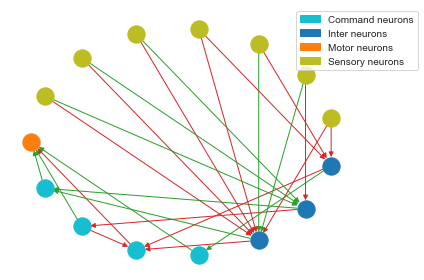

In [12]:
ncp_arch = wirings.NCP(
    inter_neurons=3,  # Number of inter neurons
    command_neurons=4,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=4,  # How many incomming syanpses has each motor neuron
)
ncp_cell = LTCCell(ncp_arch)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 7)),
        keras.layers.RNN(ncp_cell, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_cell.draw_graph(layout='shell',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
hist_ncp = ncp_model.fit(x=train_x, y=train_y, batch_size=1, epochs=100,verbose=0)

In [ ]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot()
plt.plot(hist_ncp.history["loss"],label='ncp')
data_ltc_gesture = np.loadtxt('ltc_train_loss_ozone.txt')
x_ltc_gesture = data_ltc_gesture[:, 0]
y_ltc_gesture = data_ltc_gesture[:, 1]
plt.plot(x_ltc_gesture, y_ltc_gesture,'r',label="original-ltc")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# To compute sparsity
fc_wiring = wirings.FullyConnected(8, 1)  # 8 units, 1 of which is a motor neuron
ltc_cell = LTCCell(fc_wiring)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 7)),
        keras.layers.RNN(ltc_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

In [ ]:
sparsity = 1 - ncp_cell.synapse_count /ltc_cell.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))

In [ ]:
ncp_model.evaluate(valid_x,valid_y)